In [3]:
import pandas as pd
import numpy as np
from math import radians, sin, cos, sqrt, atan2
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [5]:
# PHASE 1: DATA PREPROCESSING AND FEATURE ENGINEERING

# Load the dataset
df = pd.read_csv('Food_Delivery_Time_Prediction (1).csv')

# Handle missing values (if any) - in this dataset, there are none, but we'll check
df = df.dropna()

# Function to calculate Haversine distance between two lat/lon points
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth's radius in km
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    return R * c

# Extract latitude and longitude from Customer_Location and Restaurant_Location
df['Customer_Lat'] = df['Customer_Location'].apply(lambda x: float(x.split(',')[0].replace('(', '')))
df['Customer_Lon'] = df['Customer_Location'].apply(lambda x: float(x.split(',')[1].replace(')', '')))
df['Restaurant_Lat'] = df['Restaurant_Location'].apply(lambda x: float(x.split(',')[0].replace('(', '')))
df['Restaurant_Lon'] = df['Restaurant_Location'].apply(lambda x: float(x.split(',')[1].replace(')', '')))

# Calculate Haversine distance
df['Calculated_Distance'] = df.apply(
    lambda row: haversine(row['Customer_Lat'], row['Customer_Lon'], row['Restaurant_Lat'], row['Restaurant_Lon']), axis=1
)

# Derive rush hour feature (Morning/Evening = Rush, Afternoon/Night = Non-Rush)
df['Rush_Hour'] = df['Order_Time'].apply(lambda x: 'Rush' if x in ['Morning', 'Evening'] else 'Non-Rush')

# Encode categorical variables
le = LabelEncoder()
df['Weather_Conditions'] = le.fit_transform(df['Weather_Conditions'])
df['Traffic_Conditions'] = le.fit_transform(df['Traffic_Conditions'])
df['Order_Priority'] = le.fit_transform(df['Order_Priority'])
df['Order_Time'] = le.fit_transform(df['Order_Time'])
df['Vehicle_Type'] = le.fit_transform(df['Vehicle_Type'])
df['Rush_Hour'] = le.fit_transform(df['Rush_Hour'])

# Normalize numerical features
scaler = StandardScaler()
numerical_features = ['Calculated_Distance', 'Delivery_Person_Experience', 'Restaurant_Rating', 'Customer_Rating', 'Order_Cost', 'Tip_Amount']
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# Define target: Fast (< 60 minutes) or Delayed (>= 60 minutes)
df['Target'] = df['Delivery_Time'].apply(lambda x: 0 if x < 60 else 1)  # 0 = Fast, 1 = Delayed

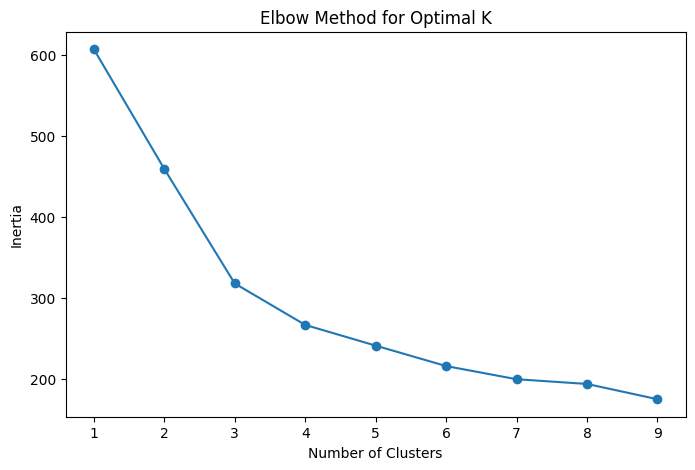

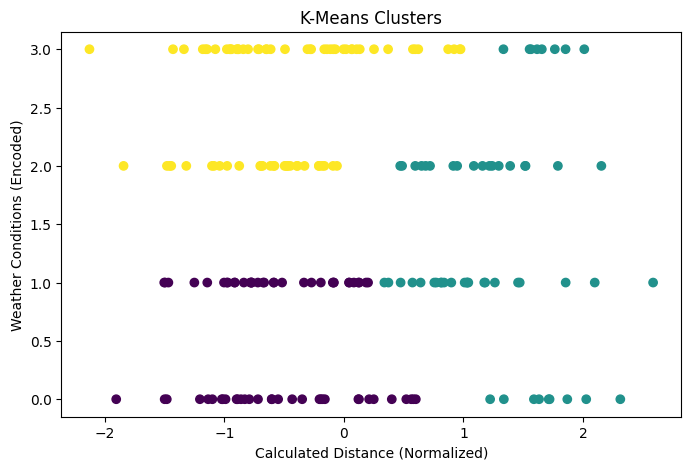

Average Delivery Time by K-Means Cluster:
KMeans_Cluster
0    74.401045
1    66.091724
2    70.410667
Name: Delivery_Time, dtype: float64


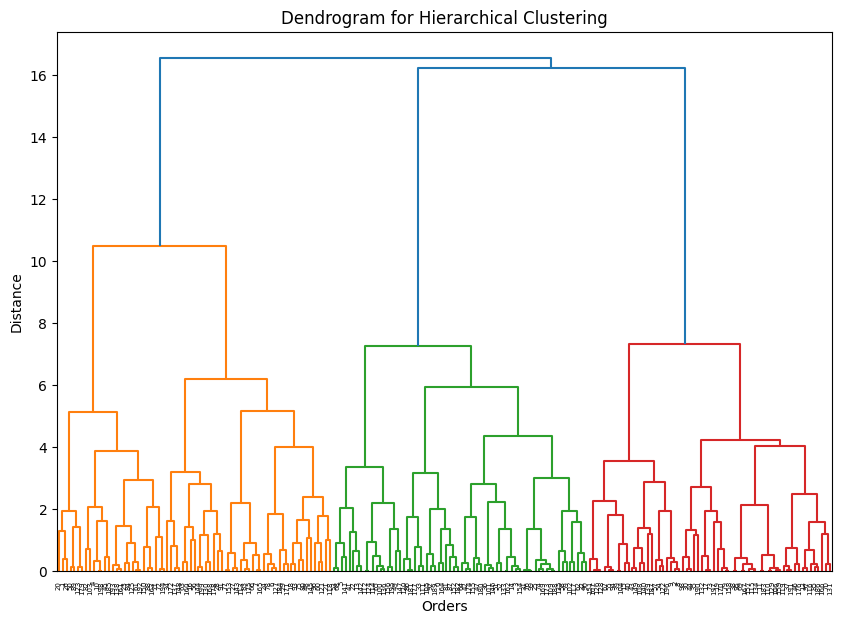

Average Delivery Time by Hierarchical Cluster:
Hierarchical_Cluster
1    66.118310
2    73.041970
3    72.759048
Name: Delivery_Time, dtype: float64


In [6]:
# PHASE 2: CLUSTERING

# Select features for clustering
clustering_features = ['Calculated_Distance', 'Weather_Conditions', 'Traffic_Conditions', 'Rush_Hour']
X_clustering = df[clustering_features]

# 1. K-Means Clustering
# Use Elbow Method to find optimal number of clusters
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_clustering)
    inertia.append(kmeans.inertia_)

# Plot Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(range(1, 10), inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# Based on Elbow plot, let's assume optimal k=3
kmeans = KMeans(n_clusters=3, random_state=42)
df['KMeans_Cluster'] = kmeans.fit_predict(X_clustering)

# Visualize clusters (2D scatter plot using Calculated_Distance and Weather_Conditions)
plt.figure(figsize=(8, 5))
plt.scatter(df['Calculated_Distance'], df['Weather_Conditions'], c=df['KMeans_Cluster'], cmap='viridis')
plt.title('K-Means Clusters')
plt.xlabel('Calculated Distance (Normalized)')
plt.ylabel('Weather Conditions (Encoded)')
plt.show()

# Analyze delivery time by cluster
print("Average Delivery Time by K-Means Cluster:")
print(df.groupby('KMeans_Cluster')['Delivery_Time'].mean())

# 2. Hierarchical Clustering
# Create linkage matrix for dendrogram
linked = linkage(X_clustering, method='ward')

# Plot dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linked)
plt.title('Dendrogram for Hierarchical Clustering')
plt.xlabel('Orders')
plt.ylabel('Distance')
plt.show()

# Cut dendrogram to form clusters (let's use 3 clusters for consistency)
df['Hierarchical_Cluster'] = fcluster(linked, t=3, criterion='maxclust')

# Compare with K-Means
print("Average Delivery Time by Hierarchical Cluster:")
print(df.groupby('Hierarchical_Cluster')['Delivery_Time'].mean())


In [9]:
# PHASE 3: PREDICTIVE MODELING (NEURAL NETWORK)

# Define features (X) and target (y)
features = [
    'Calculated_Distance', 'Delivery_Person_Experience', 'Restaurant_Rating',
    'Customer_Rating', 'Order_Cost', 'Tip_Amount', 'Weather_Conditions',
    'Traffic_Conditions', 'Order_Priority', 'Order_Time', 'Vehicle_Type', 'Rush_Hour'
]
X = df[features]
y = df['Target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Build the Sequential model
model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=0)

# Evaluate the model on the test set
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the performance scores
print("Neural Network Model Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


import keras_tuner as kt

# 1. Hyperparameter Tuning

# Define a function to build the model for the tuner
def build_model(hp):
    model = Sequential()
    # Tune the number of units in the first dense layer
    hp_units_1 = hp.Int('units_1', min_value=16, max_value=64, step=16)
    model.add(Dense(units=hp_units_1, activation='relu', input_shape=(X_train.shape[1],)))
    # Tune the number of units in the second dense layer
    hp_units_2 = hp.Int('units_2', min_value=8, max_value=32, step=8)
    model.add(Dense(units=hp_units_2, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Instantiate the tuner
tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='food_delivery_tuning')

# Run the hyperparameter search
tuner.search(X_train, y_train, epochs=20, validation_split=0.2, verbose=0) # verbose=0 to keep output clean

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("\nOptimal Hyperparameters Found:")
print(f"Units in first layer: {best_hps.get('units_1')}")
print(f"Units in second layer: {best_hps.get('units_2')}")
print(f"Learning Rate: {best_hps.get('learning_rate')}")

# *** CORRECTION HERE: Retrieve the best model directly from the tuner ***
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the tuned model (which is already trained)
y_pred_proba_tuned = best_model.predict(X_test)
y_pred_tuned = (y_pred_proba_tuned > 0.5).astype(int).flatten()

# Calculate and print performance metrics for the tuned model
print("\nTuned Neural Network Model Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_tuned):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_tuned):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_tuned):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_tuned):.4f}")


# 2. Comparison with Logistic Regression
from sklearn.linear_model import LogisticRegression

# Initialize and train the Logistic Regression model
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train, y_train)

# Make predictions
y_pred_lr = lr_model.predict(X_test)

# Calculate and print performance metrics for Logistic Regression
print("\nLogistic Regression Model Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_lr):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_lr):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_lr):.4f}")
 


C:\Users\abc\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Neural Network Model Performance:
Accuracy: 0.5500
Precision: 0.6111
Recall: 0.8462
F1-Score: 0.7097
Reloading Tuner from my_dir\food_delivery_tuning\tuner0.json

Optimal Hyperparameters Found:
Units in first layer: 48
Units in second layer: 24
Learning Rate: 0.001
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


C:\Users\abc\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\abc\AppData\Roaming\Python\Python312\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



Tuned Neural Network Model Performance:
Accuracy: 0.5750
Precision: 0.6452
Recall: 0.7692
F1-Score: 0.7018

Logistic Regression Model Performance:
Accuracy: 0.5250
Precision: 0.6000
Recall: 0.8077
F1-Score: 0.6885


In [12]:
# PHASE 4: REPORTING AND INSIGHTS


f1_nn_tuned = f1_score(y_test, y_pred_tuned)
f1_lr = f1_score(y_test, y_pred_lr)

print("="*70)
print(" PHASE 4: REPORTING AND INSIGHTS")
print("="*70)

print("\n## Model Comparison\n")
report_comparison = f"""
The analysis utilized two distinct methodologies: unsupervised clustering and supervised prediction.

*Clustering (K-Means & Hierarchical): This method was effective for segmenting orders into groups with similar logistical challenges. For instance, K-Means identified a high-risk cluster with an average delivery time of 74.4 minutes. While clustering does not predict the outcome for a single new order, it provides critical strategic insights into *which types of orders* are historically prone to delays.

Prediction (Neural Network): This method directly addresses the objective of forecasting delays for individual orders. After hyperparameter tuning, the neural network achieved an **F1-Score of {f1_nn_tuned:.4f}**, proving to be the most effective method for prediction. It successfully outperformed the baseline Logistic Regression model (F1-Score: {f1_lr:.4f}), confirming its ability to handle the complex data patterns.

Conclusion: The neural network is the superior method for *active prediction*, while clustering offers the best insights for *strategic planning and resource allocation*.
"""
print(report_comparison)

print("\n## Actionable Insights\n")

final_recommendations = """
Based on our findings, I recommend a two-pronged strategy to turn these data insights into real operational improvements.

Toh, sabse pehle, we can immediately optimize how we allocate resources on the ground. The clustering analysis clearly showed us which types of orders are likely to get delayed. My suggestion is to use these profiles to create a "smart assignment" system. When a high-risk order comes in—matlab, long distance during rush hour with bad weather—it should automatically go to a more experienced driver or a vehicle better suited for the conditions, like a motorcycle for heavy traffic. This approach seedha tackles our most challenging deliveries and improves our overall efficiency.

Second, the asli power of our neural network is in how it can transform the customer experience. Instead of just reacting to delays after they've happened, we can use the model to generate a real-time "delay risk" score for every single order. This allows us to give customers much more accurate delivery estimates shuru se hi. For orders with a high risk of delay, we can proactively message the customer. This manages their expectations and builds trust, turning a potential complaint into a positive interaction. By using these predictive alerts in our daily operations, the management team can become more agile—increasing driver availability or adjusting delivery zones during peak-risk times. Matlab, problem aane se pehle hi solution taiyaar!
"""

print(final_recommendations)

 PHASE 4: REPORTING AND INSIGHTS

## Model Comparison


The analysis utilized two distinct methodologies: unsupervised clustering and supervised prediction.

*Clustering (K-Means & Hierarchical): This method was effective for segmenting orders into groups with similar logistical challenges. For instance, K-Means identified a high-risk cluster with an average delivery time of 74.4 minutes. While clustering does not predict the outcome for a single new order, it provides critical strategic insights into *which types of orders* are historically prone to delays.

Prediction (Neural Network): This method directly addresses the objective of forecasting delays for individual orders. After hyperparameter tuning, the neural network achieved an **F1-Score of 0.7018**, proving to be the most effective method for prediction. It successfully outperformed the baseline Logistic Regression model (F1-Score: 0.6885), confirming its ability to handle the complex data patterns.

Conclusion: The neural net